In [10]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau # Для обучения нейронной сети

In [11]:
architecture = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1)
]

In [12]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))
        return x

In [13]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * split_size * split_size, 512),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.1),
            nn.Linear(512, split_size*split_size*(num_classes+num_boxes*5))
        )


    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels=x[1],
                        kernel_size=x[0],
                        stride = x[2],
                        padding = x[3]
                    )
                )
                in_channels = x[1]
            elif type(x) == str:
                layers.append(
                    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                )
            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]
                for _ in range(num_repeats):
                    layers += [
                        nn.Conv2d(
                            in_channels,
                            out_channels=conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3]
                        ),
                        nn.Conv2d(
                            in_channels=conv1[1],
                            out_channels=conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3]
                        )
                    ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.darknet(x)
        x = torch.flatten(x, start_dim=1)
        return self.fcs(x)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [15]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.S = S
        self.B = B
        self.C = C
        self.lamda_noobj = 0.5
        self.lamda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B*5)
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        bestbox = bestbox.unsqueeze(3)
        exists_box = target[..., 20].unsqueeze(3)

        ### box coordinates
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30] + (1-bestbox)* predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4])* torch.sqrt(torch.abs(box_predictions[..., 2:4]) + 1e-6)

        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(torch.flatten(box_predictions.detach(), end_dim=-2),
                            torch.flatten(box_targets, end_dim=-2))


        ### object loss

        pred_box = bestbox * predictions[..., 25:26] + (1-bestbox) * predictions[..., 20:21]
        object_loss = self.mse(
            torch.flatten(exists_box.detach()*pred_box.detach()),
            torch.flatten(exists_box.detach()*target[..., 20:21].detach())
        )
        ### no object loss

        no_object_loss = self.mse(
            torch.flatten((1-exists_box)*predictions[..., 20:21].detach(), start_dim=1),
            torch.flatten((1-exists_box)* target[..., 20:21].detach(), start_dim=1)
        )

        no_object_loss += self.mse(
            torch.flatten((1-exists_box)*predictions[..., 25:26].detach(), start_dim=1),
            torch.flatten((1-exists_box)* target[..., 20:21].detach(), start_dim=1)
        )


        ###class loss
        class_loss = self.mse(
            torch.flatten(exists_box.detach() * predictions[..., :20].detach(), end_dim=-2),
            torch.flatten(exists_box.detach() * target[..., :20].detach(), end_dim=-2)
        )


        loss = (
            self.lamda_coord*box_loss + self.lamda_noobj*no_object_loss + object_loss + class_loss
        )
        return loss

In [16]:
class YoloLoss2(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss2, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.S = S
        self.B = B
        self.C = C
        self.lamda_noobj = 0.5
        self.lamda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B*5)

        left_target_box = self.C+1
        right_target_box = self.C+1+4

        iou_b1 = intersection_over_union(predictions[..., left_target_box:right_target_box], target[..., left_target_box:right_target_box])
        iou_b2 = intersection_over_union(predictions[..., left_target_box+5:right_target_box+5], target[..., left_target_box:right_target_box])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        bestbox = bestbox.unsqueeze(3)
        exists_box = target[..., self.C].unsqueeze(3)

        ### box coordinates
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., left_target_box+5:right_target_box+5] + (1-bestbox)* predictions[..., left_target_box:right_target_box]
            )
        )

        box_targets = exists_box * target[..., left_target_box:right_target_box]

        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4])* torch.sqrt(torch.abs(box_predictions[..., 2:4]) + 1e-6)

        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(torch.flatten(box_predictions.detach(), end_dim=-2),
                            torch.flatten(box_targets, end_dim=-2))


        ### object loss

        pred_box = bestbox * predictions[..., right_target_box:right_target_box+1] + (1-bestbox) * predictions[..., self.C:left_target_box]
        object_loss = self.mse(
            torch.flatten(exists_box.detach()*pred_box),
            torch.flatten(exists_box.detach()*target[..., self.C:left_target_box])
        )
        ### no object loss

        no_object_loss = self.mse(
            torch.flatten((1-exists_box)*predictions[..., self.C:left_target_box], start_dim=1),
            torch.flatten((1-exists_box)* target[..., self.C:left_target_box], start_dim=1)
        )

        no_object_loss += self.mse(
            torch.flatten((1-exists_box)*predictions[..., right_target_box:right_target_box+1], start_dim=1),
            torch.flatten((1-exists_box)* target[..., self.C:left_target_box], start_dim=1)
        )


        ###class loss
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2)
        )


        loss = (
            self.lamda_coord*box_loss + self.lamda_noobj*no_object_loss + object_loss + class_loss
        )
        return loss

In [17]:
l = YoloLoss2(7,2,2)(torch.ones(1, 7, 7, 12).requires_grad_(), torch.ones(1, 7, 7, 7).requires_grad_())
l.backward()

NameError: name 'intersection_over_union' is not defined

In [18]:
from  torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
from torchvision import transforms

d:\mlp\machinelearning\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\mlp\MachineLearning\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [19]:
class VOCDataset(Dataset):
    def __init__(self,
                 csv_file,
                 S = 7,
                 B = 2,
                 C = 20):
        super(VOCDataset, self).__init__()
        self.annotations = pd.read_csv(csv_file)
        self.S = S
        self.B = B
        self.C = C
        self.transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((448, 448))
            ]
        )

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, item):
        img_path = self.annotations.iloc[item, 0]
        label_path = self.annotations.iloc[item, 1]
        boxes = []
        with open(label_path) as f:
            file = f.read().split('\n')[:-1]
        file = [list(map(float, x.split(' '))) for x in file]
        for i in file:
            boxes.append(i)
        image = Image.open(img_path)
        image = self.transforms(image)

        label_matrix = torch.zeros((self.S, self.S, self.C+5))

        left_target_box = self.C+1
        right_target_box = self.C+1+4

        for box in boxes:
            class_label, x,  y, width, height = box
            class_label = int(class_label)
            i, j  = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i
            width_cell, height_cell = width * self.S, height*self.S

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1
                box_coordinates = torch.tensor([
                    x_cell, y_cell, width_cell, height_cell
                ])
                label_matrix[i, j, left_target_box:right_target_box] = box_coordinates
                label_matrix[i, j, class_label] = 1

        return(image, label_matrix)

In [20]:
qq = VOCDataset('train.csv', 7,2,2)

In [21]:
qq.__getitem__(2)[1].shape

torch.Size([7, 7, 7])

In [22]:
from IntersectionOverUnion import intersection_over_union
from MeanAveragePrecision import mean_average_precision
from NonMaximumSupression import non_maximum_suppression

In [23]:
lr = 2e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
batch_size = 4
epochs = 100

In [24]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

In [25]:
model = Yolov1(3, split_size=7, num_boxes=2, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_function = YoloLoss2(7, 2, 2)
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=2, threshold=1e-3)

In [26]:
train_dataset = VOCDataset('train.csv',7,2,2)
test_dataset = VOCDataset('test.csv',7,2,2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [27]:
all_train_losses = []
all_test_losses = []

In [28]:
import matplotlib.pyplot as plt
from IPython.display import clear_output # Для отчистки графика во время обучения НС
from tqdm import tqdm

In [29]:
def train_model(model,
                num_epochs,
                loss_function,
                optimizer,
                scheduler,
                train_dataloader,
                test_dataloader):
    for epoch in range(num_epochs):
        train_loss = 0
        test_loss = 0
        model.train(True)
        print(f'epoch_number is {epoch}. Train')
        for (X, y) in tqdm(train_dataloader):
            model.zero_grad()
            X = X.to(device)
            y = y.to(device)
            preds = model.forward(X)
            loss = loss_function(preds.requires_grad_(), y.requires_grad_())
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()/ (len(train_dataloader))
            with torch.no_grad():
                torch.cuda.empty_cache()
        model.train(False)
        model.eval()
        print(f'epoch_number is {epoch}. Test')
        for (X, y) in tqdm(test_dataloader):
            with torch.no_grad():
                X = X.to(device)
                y = y.to(device)
                preds = model.forward(X)
                loss = loss_function(preds, y)
                test_loss += loss.detach().item() / (len(test_dataloader))
        scheduler.step(test_loss)
        clear_output()
        all_train_losses.append(train_loss)
        all_test_losses.append(test_loss)
        print('loss train', train_loss)
        print('loss test', test_loss)
        plt.figure(figsize = (10, 6))
        plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
        plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
        plt.legend()
        plt.ylabel('Loss')
        plt.grid()
        plt.show()

loss train 259.5988798196605
loss test 231.58856430053712


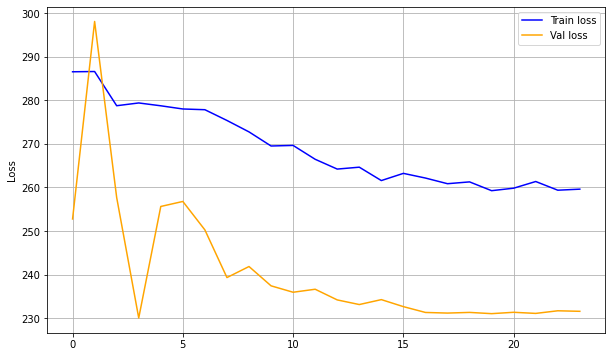

epoch_number is 24. Train


  6%|▋         | 11/173 [00:02<00:42,  3.82it/s]


KeyboardInterrupt: 

In [30]:
train_model(model, epochs, loss_function, optimizer, scheduler, train_dataloader, test_dataloader)

In [31]:
torch.save(model.state_dict(), 'yolo.pth')

In [41]:
with torch.no_grad():
    res = model(test_dataset.__getitem__(0)[0].unsqueeze(0).cuda())

In [49]:
res = res.reshape(-1, 7, 7, 2 + 2*5).tolist()

In [61]:
final = []

In [62]:
for picture in res:
    for i in range(7):
        for j in range(7):
            width1, height1 = picture[i][j][5]*7, picture[i][j][6]*7
            width2, height2 = picture[i][j][10]*7, picture[i][j][11]*7

            x1 = (picture[i][j][3]+j)/7
            y1 = (picture[i][j][4]+i)/7

            x2 = (picture[i][j][8]+j)/7
            y2 = (picture[i][j][9]+i)/7

            p1 = picture[i][j][2]
            p2 = picture[i][j][7]

            c = np.argmax([picture[i][j][0], picture[i][j][1]])
            final.append([c, p1, x1, y1, width1, height1])
            final.append([c, p2, x2, y2, width2, height2])


In [65]:
np.argmax(np.array(final)[:, 1])

50

In [75]:
bbb = np.abs(np.array(final)[:, 2:])

In [74]:
img = Image.open('dataset/dataset/images/test/TB2R28UvUOWBKNjSZKzXXXfWFXa_!!1116877752.jpg')

In [77]:
img.size

(800, 800)

In [79]:
bbb = bbb*800

In [ ]:
def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

In [80]:
import cv2

In [55]:
import numpy as np

In [40]:
test_dataset.__getitem__(0)[0].unsqueeze(0).cuda()

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7647, 0.7647],
          [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7647, 0.7647],
          [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7647, 0.7647],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.3195, 0.6049, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.3206, 0.6623, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.3190, 0.7045, 0.9985]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7608, 0.7608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7608, 0.7608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7608, 0.7608],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.2724, 0.5772, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.2735, 0.6398, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.2721, 0.6840, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.7451, 0.7451, 0.7451],
          [1.0000, 1.0000, 1.0000,  ..., 0.7451, 0.7451, 0.7451],
          [1.0000, 1.0000, 1.0000,  ..., 0

In [68]:
pd.read_csv('test.csv')

,img,label
0,dataset/dataset/images/test/TB2R28UvUOWBKNjSZK...,dataset/dataset/images/test/TB2R28UvUOWBKNjSZK...
1,dataset/dataset/images/test/US-expands-coronav...,dataset/dataset/images/test/US-expands-coronav...
2,dataset/dataset/images/test/Pakistan-China-cor...,dataset/dataset/images/test/Pakistan-China-cor...
3,dataset/dataset/images/test/RZXE24HFK5GSVKVSN5...,dataset/dataset/images/test/RZXE24HFK5GSVKVSN5...
4,dataset/dataset/images/test/TASS38012699.jpg,dataset/dataset/images/test/TASS38012699.txt
...,...,...
114,dataset/dataset/images/test/sgssgg.jpeg,dataset/dataset/images/test/sgssgg.txt
115,dataset/dataset/images/test/upload-productImg-...,dataset/dataset/images/test/upload-productImg-...
116,dataset/dataset/images/test/TELEMMGLPICT000222...,dataset/dataset/images/test/TELEMMGLPICT000222...
117,dataset/dataset/images/test/stsciRq.png,dataset/dataset/images/test/stsciRq.txt


In [23]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [19]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
with torch.autograd.set_detect_anomaly(True)

In [181]:
ex.shape

torch.Size([2, 588])

In [182]:
ex

tensor([[-0.0212,  0.0301,  0.0100,  ...,  0.0279,  0.0381,  0.0253],
        [-0.0212,  0.0301,  0.0100,  ...,  0.0279,  0.0381,  0.0253]],
       device='cuda:0')

In [185]:
YoloLoss2(7,2,2).forward(ex.cpu(), torch.ones(2, 7, 7, 7))

torch.Size([2, 7, 7, 1]) torch.Size([2, 7, 7, 4])


tensor(2296.7966)

In [164]:
torch.zeros(2, 7, 7, 1)* torch.ones(2,7,7,4)

tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [

In [15]:
ex.shape

torch.Size([2, 1470])

In [73]:
torch.ones(2, 7, 7, 25).shape

torch.Size([2, 7, 7, 25])

In [54]:
ex.shape

torch.Size([2, 1470])

In [52]:
torch.ones(2, 7, 7, 25)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         ...,

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 

In [26]:
a = torch.tensor(range(120)).reshape(4, 30)
a

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29],
        [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
          44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
          58,  59],
        [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
          74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
          88,  89],
        [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
         118, 119]])

In [32]:
q = torch.cat([intersection_over_union(a[:, 21:25], a[:, 21:25]).unsqueeze(0), intersection_over_union(a[:, 21:25], a[:, 21:25]).unsqueeze(0)])

In [37]:
torch.max(q, dim=0)

torch.return_types.max(
values=tensor([1., 1., 1., 1.]),
indices=tensor([0, 0, 0, 0]))

In [44]:
torch.tensor(range(100)).reshape(4, 25)[:, 20]

tensor([20, 45, 70, 95])